In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pybedtools

gencode_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz'
gencode_exons = pd.read_csv(gencode_exons_bed, sep='\t', 
                            names = ['chrom', 'start', 'end', 'gene_id', 
                                                           'transcript_id', 'strand', 'exon_id', 'transcript_support_level',
                                                           'basic', 'Ensembl_canonical', 'MANE_Select', 'appris', 'transcript_type'])

snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])


annotation = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/annotated.snmf.merged_isoforms.tab.gz', sep='\t')
annotation = annotation.loc[annotation.appris_transcript_length != 'appris_transcript_length']
annotation['appris_transcript_length'] = annotation.appris_transcript_length.astype(int)
annotation['gene_id'] = [x.split('.')[0] for x in annotation.transcript]

In [2]:
def plot_bed_intron(bed, start, end, hard_start, hard_end, y_pos = 0, color = 'black', ax=None):

    if ax is None:
        fig, ax = plt.subplots()

    for idx, row in bed.iterrows():
        x = np.max([((row.start - start)/(end - start)), 0])
        y = np.min([((row.end - start)/(end - start)), 1])
        ax.fill_between([x, y], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color=color, zorder=0)

def plot_bed_lines(bed, start, end, hard_start, hard_end, y_pos = 0, color = 'black', ax=None):

    if ax is None:
        fig, ax = plt.subplots()

    if len(bed) == 1:
        x = np.max([((bed.start - start)/(end - start)).iloc[0], 0])
        y = np.min([((bed.end - start)/(end - start)).iloc[0], 1])
        ax.fill_between([x, y], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color=color, zorder=1)
    else:
    
        X = ((bed.end - start)/(end - start)).iloc[:-1]
        Y = ((bed.start - start)/(end - start)).iloc[1:]
    
        if (X.iloc[0] > 0) and (X.iloc[0] < 1):
            x = X.iloc[0]
            ax.fill_between([0, x], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color=color, zorder=1)
            # ax.plot([0, x], [y_pos, y_pos], c=color, zorder=1)
    
        for i in range(len(X)-1):
            x = np.min([np.max([0, X.iloc[i+1]]), 1])
            y = np.max([np.min([1, Y.iloc[i]]), 0])
            
            ax.fill_between([x, y], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color=color, zorder=1)
    
        if (Y.iloc[-1] < 1) and (Y.iloc[-1] > 0):
            y = Y.iloc[-1]
            ax.fill_between([y, 1], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color=color, zorder=1)
            # ax.plot([y, 1], [y_pos, y_pos], c=color, zorder=1)


def extract_retained_introns(protein_coding_bed, retained_intron_bed):
    X = pybedtools.BedTool.from_dataframe(protein_coding_bed)
    Y = pybedtools.BedTool.from_dataframe(retained_intron_bed)

    intersection = Y.intersect(X, c=True).to_dataframe()
    intersection.columns = ['chrom', 'start', 'end', 'overlaps']
    Z = pybedtools.BedTool.from_dataframe(intersection.loc[intersection.overlaps >= 2])

    if len(Z) >= 1:

        Z = Z.subtract(X).to_dataframe()
        Z.start -= 1
        Z.end += 1
        Z = Z[['chrom', 'start', 'end']]
        Z = pybedtools.BedTool.from_dataframe(Z).intersect(X, c=True).to_dataframe()
        Z = Z.loc[Z.name >= 2]
    
        if len(Z) >= 1:
            Z.start += 1
            Z.end -= 1

    else:
        Z = pd.DataFrame(columns = ['chrom', 'start', 'end'])

    return Z

def get_coverage_percentage(bed, start, end, hard_start, hard_end):

    if len(bed) == 1:
        x = np.max([((merged_intron_retention.start - start)/(end - start)).iloc[0], 0])
        y = np.min([((merged_intron_retention.end - start)/(end - start)).iloc[0], 1])
        covered = np.abs(y-x)
    else:
    
        X = ((bed.end - start)/(end - start)).iloc[:-1]
        Y = ((bed.start - start)/(end - start)).iloc[1:]
    
        covered = 0
    
        if (X.iloc[0] > 0) and (X.iloc[0] < 1):
            x = X.iloc[0]
            covered += x
    
        for i in range(len(X)-1):
            x = np.min([np.max([0, X.iloc[i+1]]), 1])
            y = np.max([np.min([1, Y.iloc[i]]), 0])
            
            covered += np.abs(y-x)
    
        if (Y.iloc[-1] < 1) and (Y.iloc[-1] > 0):
            y = Y.iloc[-1]
            covered += np.abs(1-y)

    return covered

def get_intron_mean_position(bed, start, end):

    start_i = (retained_i.start - start)/(end-start)
    end_i = (retained_i.end - start)/(end-start)

    intervals = list(zip(start_i, end_i))


    # Calculate the lengths of the intervals
    lengths = [(end - start) for start, end in intervals]
    
    # Calculate the total length
    total_length = sum(lengths)
    
    # Find the point where half of the total length is reached
    half_length = total_length / 2.0
    
    # Find the cumulative lengths
    cumulative_length = 0.0
    for (start, end), length in zip(intervals, lengths):
        cumulative_length += length
        if cumulative_length >= half_length:
            # We need to move half_length - (cumulative_length - length) into the current interval
            return start + (half_length - (cumulative_length - length))
    
    # If we reach here, something went wrong (e.g., empty intervals list)
    return None



In [3]:
# fig, ax = plt.subplots(figsize=(2, 8))
counter = 0
y_pos = 0

genes_list = []
position_list = []

for gene, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):#, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):
    # df = snmf_exons.loc[snmf_exons.gene_id == gene]
    annot_slice = annotation.loc[annotation.gene_id == gene]
    annotated_isoforms = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: ('intron.chain' in x) or ('ref.transcript' in x))].transcript)
    # alt_introns = list(annot_slice.loc[annot_slice.gencode_ref != '.'].transcript)
    # annotated_isoforms = annotated_isoforms + annotated_isoforms
    

    

    retained_introns = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: 'retained.intron' in x) & (annot_slice.query_transcript_len >= 1)].transcript)

    bedtool = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(annotated_isoforms)])
    merged_bedtool = bedtool.merge().to_dataframe()
    if (len(annotated_isoforms) > 0) and (len(merged_bedtool) >= 2):
        
    
        start = merged_bedtool.end.min()
        end = merged_bedtool.start.max()
        hard_start = df.start.min()
        hard_end = df.end.max()
        
        if (len(retained_introns) > 0):
            
            merged_intron_retention = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(retained_introns)])
            merged_intron_retention = merged_intron_retention.merge().to_dataframe()

            if len(merged_intron_retention) == 1:
                percent = get_coverage_percentage(merged_intron_retention, start, end, hard_start, hard_end)
            else:
                percent = 1

            if (len(merged_intron_retention) >= 1):# or ((len(merged_intron_retention) == 1) and (percent < 0.5)):

                try:

                    retained_i = extract_retained_introns(merged_bedtool, merged_intron_retention)

                    position_i = get_intron_mean_position(retained_i, start, end)
                    genes_list.append(gene)
                    position_list.append(position_i)
                    
                    counter += 1
                except:
                    continue
                # print(counter)
    if counter >= 500:
        break


In [4]:
df_pos = pd.DataFrame()
df_pos['gene_id'] = genes_list
df_pos['position'] = position_list

In [5]:
df_pos

,gene_id,position
0,ENSG00000000005,0.634434
1,ENSG00000001561,0.921525
2,ENSG00000001629,0.841545
3,ENSG00000002549,0.325462
4,ENSG00000002726,0.380620
...,...,...
495,ENSG00000101337,0.710407
496,ENSG00000101361,0.658849
497,ENSG00000101367,0.966799
498,ENSG00000101405,0.927721


In [6]:
snmf_exons

,chrom,start,end,gene_id,transcript_id,strand,factors,exon_id
0,chr1,923874,944151,ENSG00000187634,ENSG00000187634.isoform_1,+,factor_1:factor_3:factor_4:factor_5:factor_6:f...,exon_1
1,chr1,924423,924948,ENSG00000187634,ENSG00000187634.isoform_4,+,factor_9,exon_1
2,chr1,924630,924948,ENSG00000187634,ENSG00000187634.isoform_3,+,factor_7,exon_1
3,chr1,925922,926013,ENSG00000187634,ENSG00000187634.isoform_4,+,factor_9,exon_2
4,chr1,925922,926013,ENSG00000187634,ENSG00000187634.isoform_3,+,factor_7,exon_2
...,...,...,...,...,...,...,...,...
763813,chrX,156025241,156025422,ENSG00000182484,ENSG00000182484.isoform_6,+,factor_5,exon_5
763814,chrX,156025241,156025292,ENSG00000182484,ENSG00000182484.isoform_2,+,factor_10,exon_7
763815,chrX,156025241,156025422,ENSG00000182484,ENSG00000182484.isoform_5,+,factor_4:factor_9,exon_7
763816,chrX,156025241,156025301,ENSG00000182484,ENSG00000182484.isoform_3,+,factor_2,exon_7


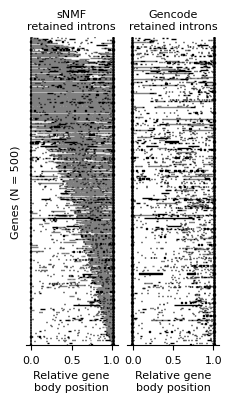

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(2.5, 4), gridspec_kw={'wspace': 0.1})

ax = axes[0]
counter = 0
y_pos = 0

for gene in df_pos.sort_values('position').gene_id: #, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):#, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):
    df = snmf_exons.loc[snmf_exons.gene_id == gene]
    annot_slice = annotation.loc[annotation.gene_id == gene]
    annotated_isoforms = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: ('intron.chain' in x) or ('ref.transcript' in x))].transcript)
    # alt_introns = list(annot_slice.loc[annot_slice.gencode_ref != '.'].transcript)
    # annotated_isoforms = annotated_isoforms + annotated_isoforms
    

    

    retained_introns = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: 'retained.intron' in x) & (annot_slice.query_transcript_len >= 1)].transcript)

    bedtool = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(annotated_isoforms)])
    merged_bedtool = bedtool.merge().to_dataframe()
    if (len(annotated_isoforms) > 0) and (len(merged_bedtool) >= 2):
        
    
        start = merged_bedtool.end.min()
        end = merged_bedtool.start.max()
        hard_start = df.start.min()
        hard_end = df.end.max()
        
        if (len(retained_introns) > 0):
            
            merged_intron_retention = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(retained_introns)])
            merged_intron_retention = merged_intron_retention.merge().to_dataframe()

            if len(merged_intron_retention) == 1:
                percent = get_coverage_percentage(merged_intron_retention, start, end, hard_start, hard_end)
            else:
                percent = 1

            if (len(merged_intron_retention) >= 1):# or ((len(merged_intron_retention) == 1) and (percent < 0.5)):

                try:

                    retained_i = extract_retained_introns(merged_bedtool, merged_intron_retention)

                

                    plot_bed_intron(retained_i, start, end, hard_start, hard_end, y_pos=y_pos, color = 'gray', ax=ax)
            
                    plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)

                    # plot_bed_lines(merged_intron_retention, start, end, hard_start, hard_end, y_pos=y_pos, color = 'red', ax=ax)
            
                    # plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)
                    ax.fill_between([-0.02, 0], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
                    ax.fill_between([1, 1.02], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
                    y_pos -= 1
                    counter += 1
                except:
                    continue
                # print(counter)
    if counter >= 500:
        break

ax.set_yticks([])
ax.set_ylabel('Genes (N = 500)', size=8)
ax.set_xlabel('Relative gene\nbody position', size=8)
ax.set_title('sNMF\nretained introns', size=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([y_pos - 0.1, 0.1])
ax.tick_params(labelsize=8)
ax.set_xticks([0, 0.5, 1])






ax = axes[1]


# fig, ax = plt.subplots(figsize=(2, 8))
counter = 0
y_pos = 0



for gene in df_pos.sort_values('position').gene_id:#, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):
    df = gencode_exons.loc[(gencode_exons.gene_id == gene)]
    
    annotated_isoforms = list(df.loc[(df.transcript_type == 'protein_coding') & (~df.appris.isna())].transcript_id)

    

    retained_introns = list(df.loc[df.transcript_type == 'retained_intron'].transcript_id)

    bedtool = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(annotated_isoforms)])
    merged_bedtool = bedtool.merge().to_dataframe()
    if (len(annotated_isoforms) > 0) and (len(merged_bedtool) >= 2):
        
    
        start = merged_bedtool.end.min()
        end = merged_bedtool.start.max()
        hard_start = df.start.min()
        hard_end = df.end.max()
        
        
            
            

        if (len(retained_introns) > 0):

            merged_intron_retention = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(retained_introns)])
            merged_intron_retention = merged_intron_retention.merge().to_dataframe()

            if len(merged_intron_retention) >= 2:


                try:

                    retained_i = extract_retained_introns(merged_bedtool, merged_intron_retention)
    
                    
    
                    plot_bed_intron(retained_i, start, end, hard_start, hard_end, y_pos=y_pos, color = 'gray', ax=ax)
                except:
                    continue
        
                
        plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)
        ax.fill_between([-0.02, 0], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
        ax.fill_between([1, 1.02], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
        y_pos -= 1
        counter += 1
                # print(counter)
    if counter >= 500:
        break


ax.set_yticks([])
# ax.set_ylabel('Genes (N = 500)', size=10)
ax.set_xlabel('Relative gene\nbody position', size=8)
ax.set_title('Gencode\nretained introns', size=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([y_pos - 0.1, 0.1])
ax.tick_params(labelsize=8)
ax.set_xticks([0, 0.5, 1])


plt.savefig('../code/scratch_figures/figure2/intron_annotation_heatmap.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_annotation_heatmap.png', bbox_inches='tight', dpi=500)

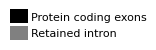

In [36]:
colores = sns.color_palette("tab10")


fig, axs = plt.subplots(2, 2, figsize=(0.5, 0.4))

colors_list = ['black', 'gray']

tissue_list_names = ['Protein coding exons', 'Retained intron']

for i, color in enumerate(colors_list):
    axs[i,0].bar([1], [1], color=color)
    axs[i,0].axis('off')  # Hide
    axs[i,0].margins(0, 0)

    axs[i,1].text(0, 0.25, tissue_list_names[i], size=8)#, c=color)
    axs[i,1].set_xticks([])
    axs[i,1].set_yticks([])
    axs[i,1].spines['right'].set_visible(False)
    axs[i,1].spines['left'].set_visible(False)
    axs[i,1].spines['top'].set_visible(False)
    axs[i,1].spines['bottom'].set_visible(False)

# axs[0].imshow(colors_list)

plt.savefig('../code/scratch_figures/figure2/exon_intron_labels.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/exon_intron_labels.png', bbox_inches='tight', dpi=500)

In [5]:
# data = np.loadtxt()

col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
pos_names = [f'bin_{str(i+1)}' for i in range(110)]

col_names += pos_names

liver_snmf_mat = pd.read_csv('../code/CoveragePlots/matrices/Liver.snmf_only.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
liver_gencode_mat = pd.read_csv('../code/CoveragePlots/matrices/Liver.gencode_only.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
liver_snmf_gencode_mat = pd.read_csv('../code/CoveragePlots/matrices/Liver.snmf_and_gencode.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)

# liver_vastdb_mat = pd.read_csv('../code/CoveragePlots/matrices/Liver.vastdb_only.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)

# liver_snmf_vastdb_mat = pd.read_csv('../code/CoveragePlots/matrices/Liver.snmf_and_vastdb.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
# liver_gencode_vastdb_mat = pd.read_csv('../code/CoveragePlots/matrices/Liver.gencode_and_vastdb.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
# liver_snmf_gencode_vastdb_mat = pd.read_csv('../code/CoveragePlots/matrices/Liver.snmf_and_gencode_and_vastdb.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)

lung_snmf_mat = pd.read_csv('../code/CoveragePlots/matrices/Lung.snmf_only.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
lung_gencode_mat = pd.read_csv('../code/CoveragePlots/matrices/Lung.gencode_only.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
lung_snmf_gencode_mat = pd.read_csv('../code/CoveragePlots/matrices/Lung.snmf_and_gencode.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)

liver_appris_mat = pd.read_csv('../code/CoveragePlots/matrices/Liver.appris_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
lung_appris_mat = pd.read_csv('../code/CoveragePlots/matrices/Lung.appris_introns.mat.gz', sep='\t', skiprows=1, names = col_names)


exon_bins = [f'bin_{str(x)}' for x in [1, 2, 3, 4, 5, 106, 107, 108, 109, 110]]


In [21]:
liver_appris_mat.shape

(62861, 116)

In [22]:
# liver_snmf_mat[pos_names]
snmf_norm_factor = liver_snmf_mat[exon_bins].mean(axis=1)
snmf_idx = snmf_norm_factor.loc[snmf_norm_factor >= 0.01].index

gencode_norm_factor = liver_gencode_mat[exon_bins].mean(axis=1)
gencode_idx = gencode_norm_factor.loc[gencode_norm_factor >= 0.01].index

# vastdb_norm_factor = liver_vastdb_mat[exon_bins].mean(axis=1)
# vastdb_idx = vastdb_norm_factor.loc[vastdb_norm_factor >= 0.01].index

# snmf_gencode_vastdb_norm_factor = liver_snmf_gencode_vastdb_mat[exon_bins].mean(axis=1)
# snmf_gencode_vastdb_idx = snmf_gencode_vastdb_norm_factor.loc[snmf_gencode_vastdb_norm_factor >= 0.01].index

snmf_gencode_norm_factor = liver_snmf_gencode_mat[exon_bins].mean(axis=1)
snmf_gencode_idx = snmf_gencode_norm_factor.loc[snmf_gencode_norm_factor >= 0.01].index

# gencode_vastdb_norm_factor = liver_gencode_vastdb_mat[exon_bins].mean(axis=1)
# gencode_vastdb_idx = gencode_vastdb_norm_factor.loc[gencode_vastdb_norm_factor >= 0.01].index

# snmf_vastdb_norm_factor = liver_snmf_vastdb_mat[exon_bins].mean(axis=1)
# snmf_vastdb_idx = snmf_vastdb_norm_factor.loc[snmf_vastdb_norm_factor >= 0.01].index

appris_norm_factor = liver_appris_mat[exon_bins].mean(axis=1)
appris_idx = appris_norm_factor.loc[appris_norm_factor >= 0.01].index

In [14]:
def plot_mat(mat, exon_bins, pos_names, ax = None, plot_range=False, sqrt_root = True, label='', zorder = 0, c='tab:blue'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))
        
    norm_factor = mat[exon_bins].mean(axis=1)
    idx = norm_factor.loc[norm_factor >= 0.01].index

    X = mat.loc[idx, pos_names].T.divide(norm_factor.loc[idx]).T
    if sqrt_root:
        X = np.sqrt(X)

    if plot_range:
        y1 = X.quantile(0.75, axis=0)
        y0 = X.quantile(0.25, axis=0)
    
        ax.fill_between(range(len(y0)), y0, y1, linewidth=0.5, alpha=0.2, color=c, zorder=zorder)

    ax.plot(list(X.mean(axis=0)), linewidth=3, label=label, zorder=zorder, c=c)


def get_boxplot_input(mat_list, label_list, exon_bins):

    ir_column = []
    label_column = []
    for i, mat in enumerate(mat_list):
        label = label_list[i]
    
        norm_factor = mat[exon_bins].mean(axis=1)
        idx = norm_factor.loc[norm_factor >= 0.01].index
        
        X = mat.loc[idx, pos_names].T.divide(norm_factor.loc[idx]).T
        y = np.minimum(np.sqrt(X[[f'bin_{str(x)}' for x in range(7, 104)]]), 1)
        ir_column += list(y.mean(axis=1))
        label_column += [label]*X.shape[0]
        
    out_df = pd.DataFrame()
    out_df['ir_percent'] = ir_column
    out_df['label'] = label_column

    return out_df

In [24]:
liver_snmf_mat.shape

(16999, 116)

In [25]:
liver_snmf_gencode_mat.shape

(2730, 116)

In [15]:
liver_snmf_gencode_vastdb_mat.shape

NameError: name 'liver_snmf_gencode_vastdb_mat' is not defined

In [ ]:
pd.concat([liver_snmf_vastdb_mat, liver_snmf_mat, liver_snmf_gencode_mat, liver_snmf_gencode_vastdb_mat], axis=0)

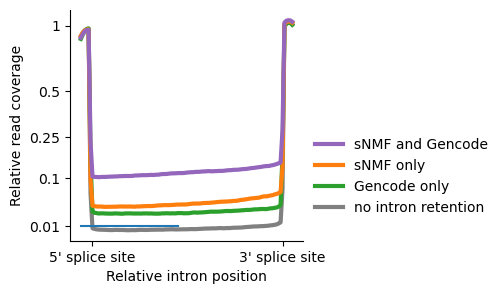

In [26]:
fig, ax = plt.subplots(figsize=(3, 3))
# plot_mat(liver_snmf_gencode_vastdb_mat, exon_bins, pos_names, ax=ax, c = 'tab:blue', zorder = 7, label='sNMF and Gencode and VastDB')
plot_mat(liver_snmf_gencode_mat, exon_bins, pos_names, ax=ax, c ='tab:purple',  zorder = 6, label='sNMF and Gencode')
# plot_mat(liver_snmf_vastdb_mat, exon_bins, pos_names, ax=ax, c ='tab:brown',  zorder = 5, label='sNMF and VastDB')

plot_mat(liver_snmf_mat, exon_bins, pos_names, ax=ax, c='tab:orange', zorder=4, label='sNMF only')
# plot_mat(liver_gencode_vastdb_mat, exon_bins, pos_names, ax=ax, c = 'goldenrod', zorder = 3, label='Gencode and VastDB')

plot_mat(liver_gencode_mat, exon_bins, pos_names, ax=ax, c='tab:green', zorder=2, label='Gencode only')
# plot_mat(liver_vastdb_mat, exon_bins, pos_names, ax=ax, c='tab:red', zorder=2, label='VastDB only')
plot_mat(liver_appris_mat, exon_bins, pos_names, ax=ax, c='gray', zorder=1, label='no intron retention')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([6, 104], ["5' splice site", "3' splice site"])
ax.set_xlabel('Relative intron position')


ax.set_yticks([0, np.sqrt(0.01), np.sqrt(0.1), np.sqrt(0.25), np.sqrt(0.5), np.sqrt(1)], ['0', '0.01', '0.1', '0.25', '0.5', '1'])

ax.set_ylabel('Relative read coverage')
ax.legend(frameon=False, bbox_to_anchor=(1, 0., 0.5, 0.5))

ax.plot([0, 50], [np.sqrt(0.01), np.sqrt(0.01)])


# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.png', bbox_inches='tight', dpi=500)

In [336]:
df = get_boxplot_input([liver_snmf_gencode_vastdb_mat, liver_snmf_gencode_mat, liver_snmf_vastdb_mat, liver_snmf_mat, 
                        liver_gencode_vastdb_mat, liver_gencode_mat, liver_vastdb_mat, liver_appris_mat], 
                  ['snmf_and_gencode_and_vastdb', 'snmf_and_gencode', 'snmf_and_vastdb', 'snmf_only',
                   'gencode_and_vastdb','gencode_only', 'vastdb_only', 'no_intron_retention'], exon_bins)

Text(0.5, 0, 'intron coverage')

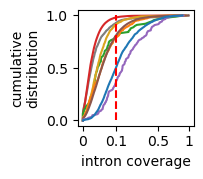

In [338]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
colores = ['tab:blue', 'tab:purple', 'tab:brown', 'tab:orange', 'goldenrod',  'tab:green', 'tab:red', 'tab:gray'][::-1]

for i, label in enumerate(['snmf_and_gencode_and_vastdb', 'snmf_and_gencode', 'snmf_and_vastdb', 'snmf_only',
                   'gencode_and_vastdb','gencode_only', 'vastdb_only', 'no_intron_retention'][::-1]):
    df_ = df.loc[df.label == label]
    c = colores[i]
    ax.plot(np.array(df_.ir_percent.sort_values()), np.linspace(0, 1, len(df_)), c=c, label=label)

ax.plot([np.sqrt(0.1), np.sqrt(0.1)], [0, 1], 'r--')

ax.set_xticks([0, np.sqrt(0.1),  np.sqrt(0.5), np.sqrt(1)], ['0',  '0.1','0.5', '1'], rotation=0)
ax.set_ylabel('cumulative\ndistribution')
# ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('intron coverage')

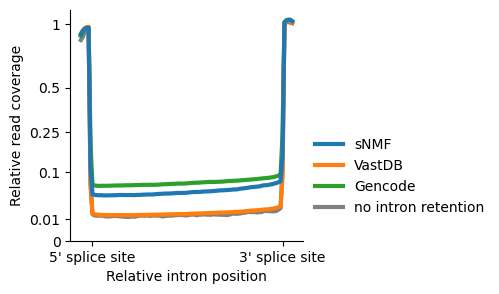

In [218]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_mat(pd.concat([liver_snmf_vastdb_mat, liver_snmf_mat, liver_snmf_gencode_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:blue', zorder = 4, label='sNMF')

plot_mat(pd.concat([liver_snmf_vastdb_mat, liver_vastdb_mat, liver_gencode_vastdb_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:orange', zorder = 3, label='VastDB')

plot_mat(pd.concat([liver_snmf_gencode_mat, liver_gencode_mat, liver_gencode_vastdb_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:green', zorder = 2, label='Gencode')

# plot_mat(liver_snmf_vastdb_mat, exon_bins, pos_names, ax=ax, c ='tab:brown',  zorder = 4, label='sNMF and VastDB')

# plot_mat(liver_gencode_vastdb_mat, exon_bins, pos_names, ax=ax, c = 'goldenrod', zorder = 4, label='Gencode and VastDB')
# plot_mat(liver_snmf_mat, exon_bins, pos_names, ax=ax, c='tab:orange', zorder=3, label='sNMF only')
# plot_mat(liver_gencode_mat, exon_bins, pos_names, ax=ax, c='tab:green', zorder=2, label='Gencode only')
# plot_mat(liver_vastdb_mat, exon_bins, pos_names, ax=ax, c='tab:red', zorder=2, label='VastDB only')
plot_mat(liver_appris_mat, exon_bins, pos_names, ax=ax, c='gray', zorder=1, label='no intron retention')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([6, 104], ["5' splice site", "3' splice site"])
ax.set_xlabel('Relative intron position')


ax.set_yticks([0, np.sqrt(0.01), np.sqrt(0.1), np.sqrt(0.25), np.sqrt(0.5), np.sqrt(1)], ['0', '0.01', '0.1', '0.25', '0.5', '1'])

ax.set_ylabel('Relative read coverage')
ax.legend(frameon=False, bbox_to_anchor=(1, 0., 0.5, 0.5))


# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.png', bbox_inches='tight', dpi=500)

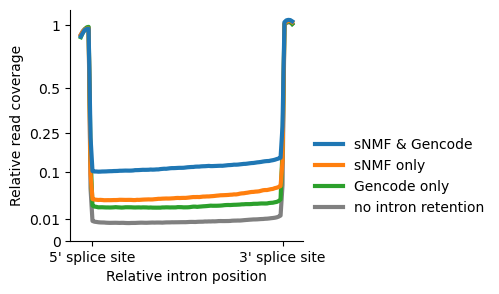

In [320]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_mat(pd.concat([liver_snmf_gencode_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:blue', zorder = 4, label='sNMF & Gencode')

plot_mat(pd.concat([liver_snmf_vastdb_mat, liver_snmf_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:orange', zorder = 3, label='sNMF only')

plot_mat(pd.concat([liver_gencode_mat, liver_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:green', zorder = 2, label='Gencode only')

# plot_mat(liver_snmf_vastdb_mat, exon_bins, pos_names, ax=ax, c ='tab:brown',  zorder = 4, label='sNMF and VastDB')

# plot_mat(liver_gencode_vastdb_mat, exon_bins, pos_names, ax=ax, c = 'goldenrod', zorder = 4, label='Gencode and VastDB')
# plot_mat(liver_snmf_mat, exon_bins, pos_names, ax=ax, c='tab:orange', zorder=3, label='sNMF only')
# plot_mat(liver_gencode_mat, exon_bins, pos_names, ax=ax, c='tab:green', zorder=2, label='Gencode only')
# plot_mat(liver_vastdb_mat, exon_bins, pos_names, ax=ax, c='tab:red', zorder=2, label='VastDB only')
plot_mat(pd.concat([liver_appris_mat, liver_vastdb_mat], axis=0).reset_index(drop=True), exon_bins, pos_names, ax=ax, c='gray', zorder=1, label='no intron retention')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([6, 104], ["5' splice site", "3' splice site"])
ax.set_xlabel('Relative intron position')


ax.set_yticks([0, np.sqrt(0.01), np.sqrt(0.1), np.sqrt(0.25), np.sqrt(0.5), np.sqrt(1)], ['0', '0.01', '0.1', '0.25', '0.5', '1'])

ax.set_ylabel('Relative read coverage')
ax.legend(frameon=False, bbox_to_anchor=(1, 0., 0.5, 0.5))


# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.png', bbox_inches='tight', dpi=500)

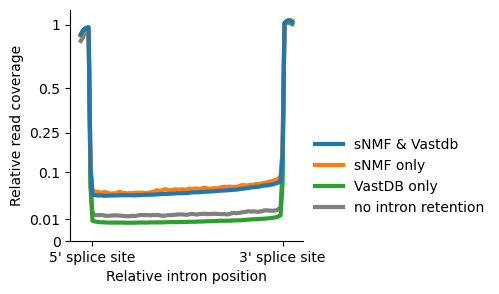

In [321]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_mat(pd.concat([liver_snmf_vastdb_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:blue', zorder = 4, label='sNMF & Vastdb')

plot_mat(pd.concat([liver_snmf_gencode_mat, liver_snmf_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:orange', zorder = 3, label='sNMF only')

plot_mat(pd.concat([liver_vastdb_mat, liver_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:green', zorder = 2, label='VastDB only')

# plot_mat(liver_snmf_vastdb_mat, exon_bins, pos_names, ax=ax, c ='tab:brown',  zorder = 4, label='sNMF and VastDB')

# plot_mat(liver_gencode_vastdb_mat, exon_bins, pos_names, ax=ax, c = 'goldenrod', zorder = 4, label='Gencode and VastDB')
# plot_mat(liver_snmf_mat, exon_bins, pos_names, ax=ax, c='tab:orange', zorder=3, label='sNMF only')
# plot_mat(liver_gencode_mat, exon_bins, pos_names, ax=ax, c='tab:green', zorder=2, label='Gencode only')
# plot_mat(liver_vastdb_mat, exon_bins, pos_names, ax=ax, c='tab:red', zorder=2, label='VastDB only')
plot_mat(pd.concat([liver_appris_mat, liver_gencode_mat], axis=0).reset_index(drop=True), exon_bins, pos_names, ax=ax, c='gray', zorder=1, label='no intron retention')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([6, 104], ["5' splice site", "3' splice site"])
ax.set_xlabel('Relative intron position')


ax.set_yticks([0, np.sqrt(0.01), np.sqrt(0.1), np.sqrt(0.25), np.sqrt(0.5), np.sqrt(1)], ['0', '0.01', '0.1', '0.25', '0.5', '1'])

ax.set_ylabel('Relative read coverage')
ax.legend(frameon=False, bbox_to_anchor=(1, 0., 0.5, 0.5))


# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.png', bbox_inches='tight', dpi=500)

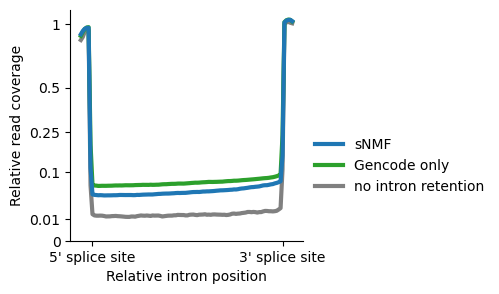

In [223]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_mat(pd.concat([liver_snmf_gencode_mat, liver_snmf_gencode_vastdb_mat, liver_snmf_vastdb_mat, liver_snmf_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:blue', zorder = 4, label='sNMF')

# plot_mat(pd.concat([liver_snmf_vastdb_mat, liver_snmf_mat], axis=0).reset_index(drop=True), 
#          exon_bins, pos_names, ax=ax, c = 'tab:orange', zorder = 4, label='sNMF only')

plot_mat(pd.concat([liver_snmf_gencode_mat, liver_snmf_gencode_vastdb_mat, liver_gencode_mat, liver_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:green', zorder = 2, label='Gencode only')

# plot_mat(liver_snmf_vastdb_mat, exon_bins, pos_names, ax=ax, c ='tab:brown',  zorder = 4, label='sNMF and VastDB')

# plot_mat(liver_gencode_vastdb_mat, exon_bins, pos_names, ax=ax, c = 'goldenrod', zorder = 4, label='Gencode and VastDB')
# plot_mat(liver_snmf_mat, exon_bins, pos_names, ax=ax, c='tab:orange', zorder=3, label='sNMF only')
# plot_mat(liver_gencode_mat, exon_bins, pos_names, ax=ax, c='tab:green', zorder=2, label='Gencode only')
# plot_mat(liver_vastdb_mat, exon_bins, pos_names, ax=ax, c='tab:red', zorder=2, label='VastDB only')
plot_mat(liver_appris_mat, exon_bins, pos_names, ax=ax, c='gray', zorder=1, label='no intron retention')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([6, 104], ["5' splice site", "3' splice site"])
ax.set_xlabel('Relative intron position')


ax.set_yticks([0, np.sqrt(0.01), np.sqrt(0.1), np.sqrt(0.25), np.sqrt(0.5), np.sqrt(1)], ['0', '0.01', '0.1', '0.25', '0.5', '1'])

ax.set_ylabel('Relative read coverage')
ax.legend(frameon=False, bbox_to_anchor=(1, 0., 0.5, 0.5))


# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.png', bbox_inches='tight', dpi=500)

In [224]:
df = get_boxplot_input([pd.concat([liver_snmf_vastdb_mat, liver_snmf_mat, liver_snmf_gencode_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
                        pd.concat([liver_gencode_vastdb_mat, liver_gencode_mat, liver_snmf_gencode_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
                        pd.concat([liver_snmf_vastdb_mat, liver_vastdb_mat, liver_gencode_vastdb_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
                        liver_appris_mat], 
                  ['snmf_and_gencode', 'snmf_only', 'gencode_only', 'no_intron_retention'], exon_bins)

Text(0.5, 0, 'intron coverage')

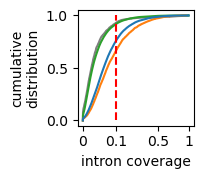

In [225]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
colores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:gray'][::-1]

for i, label in enumerate(['snmf_and_gencode', 'snmf_only', 'gencode_only', 'no_intron_retention'][::-1]):
    df_ = df.loc[df.label == label]
    c = colores[i]
    ax.plot(np.array(df_.ir_percent.sort_values()), np.linspace(0, 1, len(df_)), c=c, label=label)

ax.plot([np.sqrt(0.1), np.sqrt(0.1)], [0, 1], 'r--')

ax.set_xticks([0, np.sqrt(0.1),  np.sqrt(0.5), np.sqrt(1)], ['0',  '0.1','0.5', '1'], rotation=0)
ax.set_ylabel('cumulative\ndistribution')
# ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('intron coverage')


# plt.savefig('../code/scratch_figures/figure2/intron_cdf.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/intron_cdf.png', bbox_inches='tight', dpi=500)

In [257]:
liver_snmf_vastdb_mat.gene = liver_snmf_vastdb_mat.gene + '_snmf_vastdb'
liver_snmf_mat.gene = liver_snmf_vastdb_mat.gene + '_snmf'
liver_snmf_gencode_mat.gene = liver_snmf_vastdb_mat.gene + '_snmf_gencode'
liver_snmf_gencode_vastdb_mat.gene = liver_snmf_vastdb_mat.gene + '_snmf_gencode_vastdb'
liver_gencode_mat.gene = liver_snmf_vastdb_mat.gene + '_snmf_gencode'
liver_gencode_vastdb_mat.gene = liver_snmf_vastdb_mat.gene + '_snmf_gencode_vastdb'
liver_vastdb_mat.gene = liver_snmf_vastdb_mat.gene + '_vastdb'
liver_appris_mat.gene = liver_snmf_vastdb_mat.gene + '_appris'
# liver_gencode_mat.gene = liver_snmf_vastdb_mat.gene + '_snmf_gencode'

In [258]:
all_introns = pd.concat([liver_snmf_vastdb_mat, liver_snmf_mat, liver_snmf_gencode_mat, liver_snmf_gencode_vastdb_mat,
           liver_gencode_mat, liver_vastdb_mat, liver_gencode_vastdb_mat, liver_appris_mat], axis=0).reset_index(drop=True)

In [259]:
# ir_column = []
# label_column = []
# for i, mat in enumerate(mat_list):
#     label = label_list[i]

norm_factor = all_introns[exon_bins].mean(axis=1)
idx = norm_factor.loc[norm_factor >= 0.01].index

# X = mat.loc[idx, pos_names].T.divide(norm_factor.loc[idx]).T
# y = np.minimum(np.sqrt(X[[f'bin_{str(x)}' for x in range(7, 104)]]), 1)
# ir_column += list(y.mean(axis=1))
# label_column += [label]*X.shape[0]

In [260]:
X = all_introns.loc[idx, pos_names].T.divide(norm_factor.loc[idx]).T

In [261]:
score_df = pd.DataFrame()
score_df['event'] = list(all_introns.loc[idx].gene)
score_df['score'] = list(X[[f'bin_{str(x)}' for x in range(7, 104)]].mean(axis=1))

In [262]:
snmf_introns = list(pd.concat([liver_snmf_vastdb_mat, liver_snmf_mat, liver_snmf_gencode_mat, liver_snmf_gencode_vastdb_mat]).gene)
vastdb_introns = list(pd.concat([liver_snmf_vastdb_mat, liver_vastdb_mat, liver_gencode_vastdb_mat, liver_snmf_gencode_vastdb_mat]).gene)
gencode_introns = list(pd.concat([liver_snmf_gencode_mat, liver_gencode_mat, liver_gencode_vastdb_mat, liver_snmf_gencode_vastdb_mat]).gene)

In [278]:
score_df['snmf'] = list(score_df.event.isin(snmf_introns))
score_df['gencode'] = list(score_df.event.isin(gencode_introns))
score_df['vastdb'] = list(score_df.event.isin(vastdb_introns))
score_df['score'] = np.minimum(score_df.score, 1)

score_df = score_df.dropna()

In [284]:
score_df.sort_values('score')[::-1]

,event,score,snmf,gencode,vastdb
16200,ENSG00000198873_r7_snmf_vastdb_snmf_gencode_va...,1.0,True,True,True
9829,ENSG00000072364_r9_snmf_vastdb,1.0,True,False,True
9706,ENSG00000131730_snmf_vastdb,1.0,True,False,True
16146,ENSG00000156398_r5_snmf_vastdb_snmf_gencode_va...,1.0,True,True,True
59390,ENSG00000122378_snmf_vastdb_appris,1.0,False,False,False
...,...,...,...,...,...
16476,ENSG00000117643_r3_snmf_vastdb_vastdb,0.0,False,False,True
24600,ENSG00000118777_r9_snmf_vastdb_vastdb,0.0,False,False,True
1072,ENSG00000116147_snmf_vastdb,0.0,True,False,True
17656,ENSG00000162877_r1_snmf_vastdb_vastdb,0.0,False,False,True


In [302]:
thres = 1 - np.linspace(0, 1, 1000)

In [313]:
score_df.loc[score_df.score >= thres[999]].vastdb.mean()

0.8983743585015826

In [315]:
score_df.score.sort_values()

26572    0.0
17656    0.0
1072     0.0
24600    0.0
16476    0.0
        ... 
59390    1.0
16146    1.0
9706     1.0
9829     1.0
16200    1.0
Name: score, Length: 32541, dtype: float64

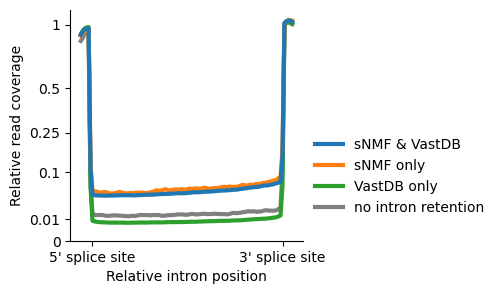

In [329]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_mat(pd.concat([liver_snmf_vastdb_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:blue', zorder = 5, label='sNMF & VastDB')

plot_mat(pd.concat([liver_snmf_gencode_mat, liver_snmf_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:orange', zorder = 4, label='sNMF only')

plot_mat(pd.concat([liver_vastdb_mat, liver_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:green', zorder = 2, label='VastDB only')

# plot_mat(liver_snmf_vastdb_mat, exon_bins, pos_names, ax=ax, c ='tab:brown',  zorder = 4, label='sNMF and VastDB')

# plot_mat(liver_gencode_vastdb_mat, exon_bins, pos_names, ax=ax, c = 'goldenrod', zorder = 4, label='Gencode and VastDB')
# plot_mat(liver_snmf_mat, exon_bins, pos_names, ax=ax, c='tab:orange', zorder=3, label='sNMF only')
# plot_mat(liver_gencode_mat, exon_bins, pos_names, ax=ax, c='tab:green', zorder=2, label='Gencode only')
# plot_mat(liver_vastdb_mat, exon_bins, pos_names, ax=ax, c='tab:red', zorder=2, label='VastDB only')
plot_mat(pd.concat([liver_appris_mat, liver_gencode_mat], axis=0).reset_index(drop=True), exon_bins, pos_names, ax=ax, c='gray', zorder=1, label='no intron retention')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([6, 104], ["5' splice site", "3' splice site"])
ax.set_xlabel('Relative intron position')


ax.set_yticks([0, np.sqrt(0.01), np.sqrt(0.1), np.sqrt(0.25), np.sqrt(0.5), np.sqrt(1)], ['0', '0.01', '0.1', '0.25', '0.5', '1'])

ax.set_ylabel('Relative read coverage')
ax.legend(frameon=False, bbox_to_anchor=(1, 0., 0.5, 0.5))


# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.png', bbox_inches='tight', dpi=500)

In [331]:
df = get_boxplot_input([pd.concat([liver_snmf_vastdb_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
                        pd.concat([liver_snmf_gencode_mat, liver_snmf_mat], axis=0).reset_index(drop=True), 
                        pd.concat([liver_vastdb_mat, liver_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
                        liver_appris_mat], 
                  ['snmf_and_vastdb', 'snmf_only', 'vastdb_only', 'no_intron_retention'], exon_bins)

Text(0.5, 0, 'intron coverage')

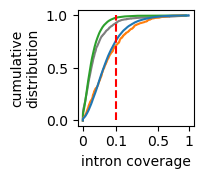

In [333]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
colores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:gray'][::-1]

for i, label in enumerate(['snmf_and_vastdb', 'snmf_only', 'vastdb_only', 'no_intron_retention'][::-1]):
    df_ = df.loc[df.label == label]
    c = colores[i]
    ax.plot(np.array(df_.ir_percent.sort_values()), np.linspace(0, 1, len(df_)), c=c, label=label)

ax.plot([np.sqrt(0.1), np.sqrt(0.1)], [0, 1], 'r--')

ax.set_xticks([0, np.sqrt(0.1),  np.sqrt(0.5), np.sqrt(1)], ['0',  '0.1','0.5', '1'], rotation=0)
ax.set_ylabel('cumulative\ndistribution')
# ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('intron coverage')


In [46]:
df = get_boxplot_input([liver_snmf_gencode_mat, liver_snmf_mat, liver_gencode_mat, liver_appris_mat], 
                  ['snmf_and_gencode', 'snmf_only', 'gencode_only', 'no_intron_retention'], exon_bins)

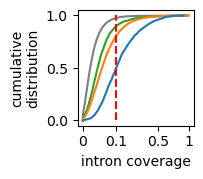

In [57]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
colores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:gray'][::-1]

for i, label in enumerate(['snmf_and_gencode', 'snmf_only', 'gencode_only', 'no_intron_retention'][::-1]):
    df_ = df.loc[df.label == label]
    c = colores[i]
    ax.plot(np.array(df_.ir_percent.sort_values()), np.linspace(0, 1, len(df_)), c=c, label=label)

ax.plot([np.sqrt(0.1), np.sqrt(0.1)], [0, 1], 'r--')

ax.set_xticks([0, np.sqrt(0.1),  np.sqrt(0.5), np.sqrt(1)], ['0',  '0.1','0.5', '1'], rotation=0)
ax.set_ylabel('cumulative\ndistribution')
# ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('intron coverage')


plt.savefig('../code/scratch_figures/figure2/intron_cdf.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_cdf.png', bbox_inches='tight', dpi=500)

In [59]:
liver_snmf_mat.shape

(19828, 116)

In [61]:
liver_gencode_mat.shape

(2032, 116)

In [64]:
liver_snmf_gencode_mat.shape

(2730, 116)

In [68]:
liver_appris_mat.shape

(55037, 116)

/tmp/jobs/41308017/ipykernel_30407/2172015292.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '1e4', '2e4', '3e4', '4e4', '5e5'])


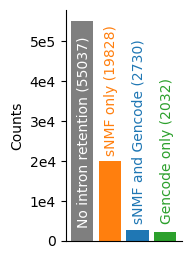

In [101]:
fig, ax = plt.subplots(figsize=(1.5, 3))

ax.bar(['No intron\nretention', 'sNMF only', 'sNMF and Gencode', 'Gencode only'], [55037, 19828, 2730, 2032],
       color = ['tab:gray', 'tab:orange', 'tab:blue', 'tab:green'])
ax.set_xticks([])
ax.text(-0.2, 4000, 'No intron retention (55037)', rotation=90, c='white')
ax.text(0.8, 22000, 'sNMF only (19828)', rotation=90, c='tab:orange')
ax.text(1.8, 5000, 'sNMF and Gencode (2730)', rotation=90, c='tab:blue')
ax.text(2.8, 5000, 'Gencode only (2032)', rotation=90, c='tab:green')
ax.set_yticklabels(['0', '1e4', '2e4', '3e4', '4e4', '5e5'])
ax.set_ylabel('Counts')
ax.spines[['right', 'top']].set_visible(False)

plt.savefig('../code/scratch_figures/figure2/intron_barplot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_barplot.png', bbox_inches='tight', dpi=500)

In [102]:
snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])

gencode_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz'
gencode_exons = pd.read_csv(gencode_exons_bed, sep='\t', 
                            names = ['chrom', 'start', 'end', 'gene_id', 
                                                           'transcript_id', 'strand', 'exon_id', 'transcript_support_level',
                                                           'basic', 'Ensembl_canonical', 'MANE_Select', 'appris', 'transcript_type'])

In [103]:
def is_subchain(introns_a, introns_b):
    # if not all(intron in introns_a for intron in introns_b):
    #     return 'no.match'

    if introns_a == introns_b:
        return 'chain.match'

    intron_chain_length_a = len(introns_a)
    intron_chain_length_b = len(introns_b)

    if intron_chain_length_a > intron_chain_length_b:
        diff_chain = intron_chain_length_a - intron_chain_length_b
        # print(diff_chain)
        for i in range(diff_chain+1):
            if (introns_b == introns_a[i:intron_chain_length_b+i]):
                
                return 'subchain.b'
    elif intron_chain_length_a < intron_chain_length_b:
        diff_chain = intron_chain_length_b - intron_chain_length_a
        # print(diff_chain)
        for i in range(diff_chain+1):
            # print(introns_b[i:intron_chain_length_a+i])
            if (introns_a == introns_b[i:intron_chain_length_a+i]):
                return 'subchain.a'

    return 'no.match'


def get_intron_chain(transcript_bed):
    if pd.DataFrame(transcript_bed).shape[1] > 3:
        intron_chain = []
        for x in zip(transcript_bed.end[:-1], transcript_bed.start[1:]):
            intron_chain.append(x)
    else:
        intron_chain = None
        
    return intron_chain


def compare_transcript_v_annotation(transcript_bed, input_transcript, exons, gene):
    snmf_iso = get_intron_chain(transcript_bed)
    
    utr_annot = []
    chain_annot = []
    transcript_list = []
    
    for transcript, df in exons.loc[exons.gene_id == gene].groupby('transcript_id'):
        if transcript == input_transcript:
            continue
        annot_iso = get_intron_chain(df)
        chain_match = is_subchain(snmf_iso, annot_iso)
    
        chain_annot.append(chain_match) 
        transcript_list.append(chain_match+ ':' + transcript)
    
        # if (chain_match == 'subchain.a') or (chain_match == 'chain.match'):
        #     # print(snmf_iso)
        #     print(transcript)
        if df.iloc[0].strand == '+':
            if snmf_iso[-1][1] == annot_iso[-1][1]:
                snmf_last = int(transcript_bed.iloc[-1].end)
                gencode_last = int(df.iloc[-1].end)
                diff = np.abs(snmf_last - gencode_last)
                if diff <= 200:
                    utr_annot.append('annotated')
                else:
                    utr_annot.append('alt.utr')
            else:
                utr_annot.append('other')
                
        elif df.iloc[0].strand == '-':
            if snmf_iso[0][0] == annot_iso[0][0]:
                snmf_last = int(transcript_bed.iloc[0].start)
                gencode_last = int(df.iloc[0].start)
                diff = np.abs(snmf_last - gencode_last)
                if diff <= 200:
                    utr_annot.append('annotated')
                else:
                    utr_annot.append('alt.utr')
            else:
                utr_annot.append('other')

    df_ = pd.DataFrame()
    df_['chain_annot'] = chain_annot
    df_['utr_annot'] = utr_annot
    df_['transcript'] = transcript_list
    return df_
    


def get_annotation_transcript(snmf_exons, gencode_exons, transcript):
    gene = transcript.split('.')[0]
    transcript_bed = snmf_exons.loc[snmf_exons.transcript_id == transcript]
    try:
        df_gencode = compare_transcript_v_annotation(transcript_bed, transcript, gencode_exons, gene)
        df_snmf = compare_transcript_v_annotation(transcript_bed, transcript, snmf_exons, gene)
    
        # print(df_gencode)
        if ('chain.match' in list(df_gencode.chain_annot)) or ('subchain.a' in list(df_gencode.chain_annot)):
            
            if 'annotated' in list(df_gencode.loc[df_gencode.chain_annot.isin(['chain.match', 'subchain.a'])].utr_annot):
                gencode_annot = 'annotated_chain.annotated_utr'
            else:
                gencode_annot = 'annotated_chain.alt_utr'
        else:
            if 'annotated' in list(df_gencode.utr_annot):
                gencode_annot = 'unannotated_chain.annotated_utr'
            else:
                gencode_annot = 'unannotated_chain.alt_utr'
    
        snmf_annot = 'no_alt'
    
        if ('chain.match' in list(df_snmf.chain_annot)) or ('subchain.a' in list(df_snmf.chain_annot)) or ('subchain.b' in list(df_snmf.chain_annot)):
            if 'alt.utr' in list(df_snmf.loc[df_snmf.chain_annot.isin(['chain.match', 'subchain.a', 'subchain.b'])].utr_annot):
                snmf_annot = 'alt.utr'
    except:
        return 'unannotated_chain.annotated_utr', 'no_alt'

    return gencode_annot, snmf_annot

def define_annotation(snmf_exons, gencode_exons, transcript, annotation):
    gencode_annot, snmf_annot = get_annotation_transcript(snmf_exons, gencode_exons, transcript)
    gencode_chain, gencode_utr = gencode_annot.split('.')

    ri = 'retained.intron' in annotation.loc[annotation.transcript == transcript].appris_ref.iloc[0]
    
    if (gencode_chain == 'annotated_chain'):
        chain = 'annotated_chain'
    else:
        chain = 'unannotated_chain'

    if ri:
        if chain == 'annotated_chain':
            ir = 'annotated.intron_retention'
        elif chain == 'unannotated_chain':
            ir = 'unannotated.intron_retention'
    else:
        ir = 'no_intron_retention'
        
    if gencode_utr == 'annotated_utr':
        if snmf_annot == 'alt.utr':
            utr = 'annotated:alt.utr'
        else:
            utr = 'no_utr'
            
    else:
        if snmf_annot == 'alt.utr':
            utr = 'unannotated:alt.utr'
        else:
            utr = 'no_utr'

    return chain, ir, utr
        
        

In [108]:
transcripts = list(snmf_exons.transcript_id.unique())

In [110]:
transcripts

['ENSG00000187634.isoform_1',
 'ENSG00000187634.isoform_4',
 'ENSG00000187634.isoform_3',
 'ENSG00000187634.isoform_2',
 'ENSG00000188976.isoform_7',
 'ENSG00000188976.isoform_5',
 'ENSG00000188976.isoform_1',
 'ENSG00000188976.isoform_4',
 'ENSG00000188976.isoform_2',
 'ENSG00000188976.isoform_6',
 'ENSG00000188976.isoform_3',
 'ENSG00000187961.isoform_1',
 'ENSG00000187961.isoform_6',
 'ENSG00000187961.isoform_5',
 'ENSG00000187961.isoform_4',
 'ENSG00000187961.isoform_2',
 'ENSG00000187961.isoform_7',
 'ENSG00000187961.isoform_8',
 'ENSG00000187961.isoform_3',
 'ENSG00000187583.isoform_5',
 'ENSG00000187583.isoform_6',
 'ENSG00000187583.isoform_9',
 'ENSG00000187583.isoform_4',
 'ENSG00000187583.isoform_2',
 'ENSG00000187583.isoform_10',
 'ENSG00000187583.isoform_7',
 'ENSG00000187583.isoform_1',
 'ENSG00000187583.isoform_8',
 'ENSG00000187583.isoform_3',
 'ENSG00000187642.isoform_4',
 'ENSG00000187642.isoform_1',
 'ENSG00000187642.isoform_2',
 'ENSG00000187642.isoform_3',
 'ENSG000

In [109]:
from tqdm import tqdm
intron_retention = 0
unannot_intron_retention = 0
alt_utr = 0
unannot_alt_utr = 0
annotated_chain_other = 0
unannotated_chain_other = 0

multiple = 0

ir_annot_list = []
utr_annot_list = []
chain_annot_list = []

for isoform in tqdm(transcripts, leave=True, position=0):
    chain_annot, ir_annot, alt_utr_annot = define_annotation(snmf_exons, gencode_exons, isoform, annotation)
    chain_annot_list.append(chain_annot)
    ir_annot_list.append(ir_annot)
    utr_annot_list.append(alt_utr_annot)
    

  7%|██▌                                 | 6168/87044 [18:55<3:48:52,  5.89it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [177]:
exons = pd.read_csv('/project2/yangili1/cfbuenabadn/CSQ_additional_files/EVENT_INFO-hg38.tab.gz', sep='\t')#[['GENE', 'EVENT', 'COMPLEX', 'CO_C1', 
                                                                                                            # 'CO_A', 'CO_C2', 'LE_n']]
exons = exons.dropna()
exons_cols = list(exons.columns)
exons['chrom'] = exons.CO_A.apply(lambda x: x.split(':')[0])
exons['start'] = exons.CO_A.apply(lambda x: x.split(':')[1].split('-')[0])
exons['end'] = exons.CO_A.apply(lambda x: x.split('-')[1])
exons_cols = ['chrom', 'start', 'end'] + exons_cols
exons = exons[exons_cols]

In [178]:
genes = pd.read_csv('../data/protein_coding_genes.bed.gz', sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand'])

In [179]:
exons = exons.loc[exons.COMPLEX == 'IR', ['chrom', 'start', 'end', 'EVENT']].reset_index(drop=True)

In [180]:
exons = pybedtools.BedTool.from_dataframe(exons)
genes = pybedtools.BedTool.from_dataframe(genes)

In [182]:
exons

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes
0,chr19,58347641,58350369,HsaINT0000004,.,-1,-1,.,-1,.,0
1,chr19,58347030,58347352,HsaINT0000005,.,-1,-1,.,-1,.,0
2,chr19,58353045,58353378,HsaINT1000001,.,-1,-1,.,-1,.,0
3,chr19,58353475,58353713,HsaINT1000002,.,-1,-1,.,-1,.,0
4,chr19,58353858,58354368,HsaINT1000003,.,-1,-1,.,-1,.,0
...,...,...,...,...,...,...,...,...,...,...,...
193590,chr7,66775394,66783674,HsaINT0136424,.,-1,-1,.,-1,.,0
193591,chr7,66783842,66795510,HsaINT0136425,.,-1,-1,.,-1,.,0
193592,chr7,66795593,66796775,HsaINT0136426,.,-1,-1,.,-1,.,0
193593,chr8,142775695,142775905,HsaINT0097886,chr8,142771197,142777810,ENSG00000180155,LYNX1,-,210


In [183]:
exons = exons.intersect(genes, f=1, wao=True).to_dataframe()
exons = exons.loc[exons.blockSizes > 0, ['chrom', 'start', 'end', 'thickEnd', 'itemRgb', 'blockCount']]
exons.columns = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand']

In [ ]:
vastdb_introns

In [324]:
len(vastdb_introns.gene_id.unique())

15764

In [323]:
vastdb_introns = exons.copy()

In [325]:
vastdb_introns.start -= 3
vastdb_introns.end += 3

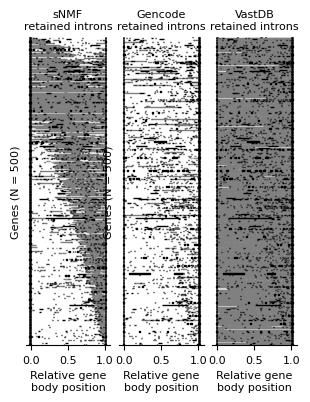

In [328]:
fig, axes = plt.subplots(ncols=3, figsize=(3.5, 4), gridspec_kw={'wspace': 0.1})

ax = axes[0]
counter = 0
y_pos = 0

for gene in df_pos.sort_values('position').gene_id: #, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):#, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):
    df = snmf_exons.loc[snmf_exons.gene_id == gene]
    annot_slice = annotation.loc[annotation.gene_id == gene]
    annotated_isoforms = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: ('intron.chain' in x) or ('ref.transcript' in x))].transcript)
    # alt_introns = list(annot_slice.loc[annot_slice.gencode_ref != '.'].transcript)
    # annotated_isoforms = annotated_isoforms + annotated_isoforms
    

    

    retained_introns = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: 'retained.intron' in x) & (annot_slice.query_transcript_len >= 1)].transcript)

    bedtool = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(annotated_isoforms)])
    merged_bedtool = bedtool.merge().to_dataframe()
    if (len(annotated_isoforms) > 0) and (len(merged_bedtool) >= 2):
        
    
        start = merged_bedtool.end.min()
        end = merged_bedtool.start.max()
        hard_start = df.start.min()
        hard_end = df.end.max()
        
        if (len(retained_introns) > 0):
            
            merged_intron_retention = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(retained_introns)])
            merged_intron_retention = merged_intron_retention.merge().to_dataframe()

            if len(merged_intron_retention) == 1:
                percent = get_coverage_percentage(merged_intron_retention, start, end, hard_start, hard_end)
            else:
                percent = 1

            if (len(merged_intron_retention) >= 1):# or ((len(merged_intron_retention) == 1) and (percent < 0.5)):

                try:

                    retained_i = extract_retained_introns(merged_bedtool, merged_intron_retention)

                

                    plot_bed_intron(retained_i, start, end, hard_start, hard_end, y_pos=y_pos, color = 'gray', ax=ax)
            
                    plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)

                    # plot_bed_lines(merged_intron_retention, start, end, hard_start, hard_end, y_pos=y_pos, color = 'red', ax=ax)
            
                    # plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)
                    ax.fill_between([-0.02, 0], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
                    ax.fill_between([1, 1.02], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
                    y_pos -= 1
                    counter += 1
                except:
                    continue
                # print(counter)
    if counter >= 500:
        break

ax.set_yticks([])
ax.set_ylabel('Genes (N = 500)', size=8)
ax.set_xlabel('Relative gene\nbody position', size=8)
ax.set_title('sNMF\nretained introns', size=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([y_pos - 0.1, 0.1])
ax.tick_params(labelsize=8)
ax.set_xticks([0, 0.5, 1])






ax = axes[1]


# fig, ax = plt.subplots(figsize=(2, 8))
counter = 0
y_pos = 0



for gene in df_pos.sort_values('position').gene_id:#, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):
    df = gencode_exons.loc[(gencode_exons.gene_id == gene)]
    
    annotated_isoforms = list(df.loc[(df.transcript_type == 'protein_coding') & (~df.appris.isna())].transcript_id)

    

    retained_introns = list(df.loc[df.transcript_type == 'retained_intron'].transcript_id)

    bedtool = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(annotated_isoforms)])
    merged_bedtool = bedtool.merge().to_dataframe()
    if (len(annotated_isoforms) > 0) and (len(merged_bedtool) >= 2):
        
    
        start = merged_bedtool.end.min()
        end = merged_bedtool.start.max()
        hard_start = df.start.min()
        hard_end = df.end.max()
        
        
            
            

        if (len(retained_introns) > 0):

            merged_intron_retention = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(retained_introns)])
            merged_intron_retention = merged_intron_retention.merge().to_dataframe()

            if len(merged_intron_retention) >= 2:


                try:

                    retained_i = extract_retained_introns(merged_bedtool, merged_intron_retention)
    
                    
    
                    plot_bed_intron(retained_i, start, end, hard_start, hard_end, y_pos=y_pos, color = 'gray', ax=ax)
                except:
                    continue
        
                
        plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)
        ax.fill_between([-0.02, 0], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
        ax.fill_between([1, 1.02], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
        y_pos -= 1
        counter += 1
                # print(counter)
    if counter >= 500:
        break


ax.set_yticks([])
# ax.set_ylabel('Genes (N = 500)', size=8)
ax.set_xlabel('Relative gene\nbody position', size=8)
ax.set_title('Gencode\nretained introns', size=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([y_pos - 0.1, 0.1])
ax.tick_params(labelsize=8)
ax.set_xticks([0, 0.5, 1])





ax = axes[2]


# fig, ax = plt.subplots(figsize=(2, 8))
counter = 0
y_pos = 0



for gene in df_pos.sort_values('position').gene_id:#, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):
    df = gencode_exons.loc[(gencode_exons.gene_id == gene)]
    
    annotated_isoforms = list(df.loc[(df.transcript_type == 'protein_coding') & (~df.appris.isna())].transcript_id)

    

    retained_introns = list(vastdb_introns.loc[vastdb_introns.gene_id == gene].index)

    bedtool = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(annotated_isoforms)])
    merged_bedtool = bedtool.merge().to_dataframe()
    if (len(annotated_isoforms) > 0) and (len(merged_bedtool) >= 2):
        
    
        start = merged_bedtool.end.min()
        end = merged_bedtool.start.max()
        hard_start = df.start.min()
        hard_end = df.end.max()
        
        
            
            

        if (len(retained_introns) > 0):


            merged_intron_retention = pybedtools.BedTool.from_dataframe(vastdb_introns.loc[vastdb_introns.gene_id == gene])
            merged_intron_retention = merged_intron_retention.sort().merge().to_dataframe()

            if len(merged_intron_retention) >= 2:


                try:

                    retained_i = extract_retained_introns(merged_bedtool, merged_intron_retention)
    
                    
    
                    plot_bed_intron(retained_i, start, end, hard_start, hard_end, y_pos=y_pos, color = 'gray', ax=ax)
                except:
                    continue
        
                
        plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)
        ax.fill_between([-0.02, 0], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
        ax.fill_between([1, 1.02], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
        y_pos -= 1
        counter += 1
                # print(counter)
    if counter >= 500:
        break


ax.set_yticks([])
# ax.set_ylabel('Genes (N = 500)', size=10)
ax.set_xlabel('Relative gene\nbody position', size=8)
ax.set_title('VastDB\nretained introns', size=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([y_pos - 0.1, 0.1])
ax.tick_params(labelsize=8)
ax.set_xticks([0, 0.5, 1])


# plt.savefig('../code/scratch_figures/figure2/intron_annotation_heatmap.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/intron_annotation_heatmap.png', bbox_inches='tight', dpi=500)

In [326]:
vastdb_introns

,chrom,start,end,gene_id,gene_name,strand
5,chr10,50859983,50885583,ENSG00000148584,A1CF,-
6,chr10,50810040,50811042,ENSG00000148584,A1CF,-
7,chr10,50806878,50809896,ENSG00000148584,A1CF,-
8,chr10,50844120,50859844,ENSG00000148584,A1CF,-
9,chr10,50841990,50843990,ENSG00000148584,A1CF,-
...,...,...,...,...,...,...
193564,chr19,44443022,44447515,ENSG00000278318,ZNF229,-
193565,chr19,44442619,44442816,ENSG00000278318,ZNF229,-
193566,chr19,44432364,44442565,ENSG00000278318,ZNF229,-
193581,chr4,25160751,25197470,ENSG00000038210,PI4K2B,+


In [111]:
exons = pd.read_csv('/project2/yangili1/cfbuenabadn/CSQ_additional_files/EVENT_INFO-hg38.tab.gz', sep='\t')
exons = exons.dropna()
exons = exons.loc[exons.COMPLEX == 'IR'].copy()
exons_cols = list(exons.columns)
exons['chrom'] = exons.CO_A.apply(lambda x: x.split(':')[0])
exons['start'] = exons.CO_A.apply(lambda x: x.split(':')[1].split('-')[0]).astype(int)
exons['end'] = exons.CO_A.apply(lambda x: x.split('-')[1]).astype(int)
exons_cols = ['chrom', 'start', 'end'] + exons_cols
exons['strand'] = exons.FULL_CO.apply(lambda x: x.split(':')[-1])

exons.start -= 1
exons.end += 1

exons = exons[['chrom', 'start', 'end', 'GENE', 'EVENT', 'strand']].copy()

genes = pd.read_csv('../data/selected_genes.bed', sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand'])

# exons = pybedtools.BedTool.from_dataframe(exons)
# genes = pybedtools.BedTool.from_dataframe(genes)

# exons = exons.intersect(genes, f=1, wao=True).to_dataframe()
# exons = exons.loc[exons.score > 0, ['chrom', 'start', 'end', 'thickStart', 'thickStart', 'itemRgb']]
# exons.columns = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand']


In [113]:
exons = exons[['chrom', 'start', 'end', 'GENE', 'EVENT', 'strand']].copy()

exons_bed = pybedtools.BedTool.from_dataframe(exons).sort()
genes_bed = pybedtools.BedTool.from_dataframe(genes).sort()

In [151]:
vastdb_exons = exons_bed.intersect(genes_bed, f=1, wao=True, s=True).to_dataframe(names = ['chrom', 'start', 'end', 'GENE', 'EVENT', 'strand',
                                                                   'chrom_gene', 'start_gene', 'end_gene', 'gene_id_gene', 
                                                                    'gene_name_gene', 'strand_gene', 'overlaps'])

vastdb_exons['intron_len'] = vastdb_exons.end - vastdb_exons.start

In [154]:
vastdb_exons = vastdb_exons.loc[vastdb_exons.overlaps >= vastdb_exons.intron_len, ['chrom', 'start', 'end', 'gene_id_gene', 'EVENT', 'strand']].copy()

In [159]:
vastdb_exons.loc[vastdb_exons.gene_id_gene == 'ENSG00000112081']

,chrom,start,end,gene_id_gene,EVENT,strand
157105,chr6,36594481,36596761,ENSG00000112081,HsaINT0159263,+
157106,chr6,36596968,36598849,ENSG00000112081,HsaINT0159264,+
157107,chr6,36598983,36601152,ENSG00000112081,HsaINT1042969,+
157108,chr6,36601190,36601708,ENSG00000112081,HsaINT0159266,+
157109,chr6,36601794,36601962,ENSG00000112081,HsaINT1042970,+


In [160]:
snmf_exons.loc[snmf_exons.transcript_id == 'ENSG00000112081.isoform_1']

,chrom,start,end,gene_id,transcript_id,strand,factors,exon_id
614196,chr6,36594379,36594481,ENSG00000112081,ENSG00000112081.isoform_1,+,factor_1,exon_1
614198,chr6,36596761,36596968,ENSG00000112081,ENSG00000112081.isoform_1,+,factor_1,exon_2
614206,chr6,36598849,36598983,ENSG00000112081,ENSG00000112081.isoform_1,+,factor_1,exon_3
614211,chr6,36601152,36601190,ENSG00000112081,ENSG00000112081.isoform_1,+,factor_1,exon_4
614216,chr6,36601708,36601794,ENSG00000112081,ENSG00000112081.isoform_1,+,factor_1,exon_5
614220,chr6,36601962,36603379,ENSG00000112081,ENSG00000112081.isoform_1,+,factor_1,exon_6


In [162]:
len(vastdb_exons.gene_id_gene.unique())

3775

In [163]:
len(snmf_exons.gene_id.unique())

15232

In [170]:
df_pos.loc[~df_pos.gene_id.isin(vastdb_exons.gene_id_gene.unique())]#.gene_id

,gene_id,position
0,ENSG00000000005,0.634434
2,ENSG00000001629,0.841545
3,ENSG00000002549,0.325462
4,ENSG00000002726,0.380620
5,ENSG00000002834,0.964227
...,...,...
494,ENSG00000101336,0.631453
495,ENSG00000101337,0.710407
496,ENSG00000101361,0.658849
497,ENSG00000101367,0.966799


In [173]:
gencode_exons.loc[gencode_exons.gene_id == 'ENSG00000000005']

,chrom,start,end,gene_id,transcript_id,strand,exon_id,transcript_support_level,basic,Ensembl_canonical,MANE_Select,appris,transcript_type
1366457,chrX,100584936,100585066,ENSG00000000005,ENST00000373031,+,ENSE00001459371,1,basic,Ensembl_canonical,MANE_Select,appris_principal_1,protein_coding
1366458,chrX,100585231,100585362,ENSG00000000005,ENST00000373031,+,ENSE00000401061,1,basic,Ensembl_canonical,MANE_Select,appris_principal_1,protein_coding
1366459,chrX,100593624,100594035,ENSG00000000005,ENST00000485971,+,ENSE00001952391,3,NaN,NaN,NaN,NaN,protein_coding_CDS_not_defined
1366460,chrX,100593895,100594035,ENSG00000000005,ENST00000373031,+,ENSE00000673400,1,basic,Ensembl_canonical,MANE_Select,appris_principal_1,protein_coding
1366461,chrX,100594261,100594362,ENSG00000000005,ENST00000373031,+,ENSE00003504197,1,basic,Ensembl_canonical,MANE_Select,appris_principal_1,protein_coding
1366462,chrX,100594261,100594362,ENSG00000000005,ENST00000485971,+,ENSE00003639486,3,NaN,NaN,NaN,NaN,protein_coding_CDS_not_defined
1366463,chrX,100597504,100597657,ENSG00000000005,ENST00000373031,+,ENSE00000673403,1,basic,Ensembl_canonical,MANE_Select,appris_principal_1,protein_coding
1366464,chrX,100597504,100597531,ENSG00000000005,ENST00000485971,+,ENSE00001881546,3,NaN,NaN,NaN,NaN,protein_coding_CDS_not_defined
1366465,chrX,100599016,100599182,ENSG00000000005,ENST00000373031,+,ENSE00000868865,1,basic,Ensembl_canonical,MANE_Select,appris_principal_1,protein_coding
1366466,chrX,100599508,100599885,ENSG00000000005,ENST00000373031,+,ENSE00001459358,1,basic,Ensembl_canonical,MANE_Select,appris_principal_1,protein_coding


In [176]:
genes#.loc[genes.gene_id == 'ENSG00000000005']

,chrom,start,end,gene_id,gene_name,strand
0,chr1,960584,965719,ENSG00000187961,KLHL17,+
1,chr1,998964,1000097,ENSG00000188290,HES4,-
2,chr1,1020120,1056116,ENSG00000188157,AGRN,+
3,chr1,1081823,1116089,ENSG00000131591,C1orf159,-
4,chr1,1216931,1232001,ENSG00000078808,SDF4,-
...,...,...,...,...,...,...
3786,chr22,50568861,50578455,ENSG00000205560,CPT1B,-
3787,chr22,50578963,50582849,ENSG00000100288,CHKB,-
3788,chr22,50622754,50628170,ENSG00000100299,ARSA,-
3789,chr22,50674892,50733212,ENSG00000251322,SHANK3,+


In [174]:
exons.loc[(exons.chrom == 'chrX') & (exons.start >= 100584936) & (exons.end <= 100599885)]

,chrom,start,end,GENE,EVENT,strand
394092,chrX,100585066,100585231,TNMD,HsaINT0170315,+
394093,chrX,100585362,100593895,TNMD,HsaINT0170316,+
394094,chrX,100594035,100594261,TNMD,HsaINT0170317,+
394095,chrX,100594362,100597504,TNMD,HsaINT0170318,+
394096,chrX,100597657,100599016,TNMD,HsaINT0170319,+
394097,chrX,100599182,100599508,TNMD,HsaINT0170320,+


In [1]:
liver_snmf_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.snmf_only.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
liver_gencode_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.gencode_only.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
liver_snmf_gencode_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.snmf_and_gencode.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)

liver_vastdb_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.vastdb_only.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)

liver_snmf_vastdb_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.snmf_and_vastdb.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
liver_gencode_vastdb_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.gencode_and_vastdb.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
liver_snmf_gencode_vastdb_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.snmf_and_gencode_and_vastdb.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)

liver_appris_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.appris_introns.mat.gz', sep='\t', skiprows=1, names = col_names)



NameError: name 'pd' is not defined

In [10]:
liver_snmf_vastdb_mat

,chrom,start,end,gene,score,strand,bin_1,bin_2,bin_3,bin_4,...,bin_101,bin_102,bin_103,bin_104,bin_105,bin_106,bin_107,bin_108,bin_109,bin_110
0,chr1,930336,931039,ENSG00000187634_snmf_intron_3,0.0,+,0.032562,0.033520,0.047311,0.048460,...,0.000000,0.000000,0.001642,0.001368,0.007901,0.036584,0.030072,0.028348,0.031604,0.034860
1,chr1,931089,935772,ENSG00000187634_snmf_intron_4,0.0,+,0.036584,0.030072,0.028348,0.031604,...,0.011044,0.012308,0.011044,0.003912,0.008273,0.062826,0.064741,0.067997,0.076233,0.082746
2,chr1,935896,939040,ENSG00000187634_snmf_intron_5,0.0,+,0.049035,0.050375,0.057845,0.056313,...,0.002634,0.005190,0.003232,0.004016,0.006405,0.050950,0.054398,0.060719,0.071828,0.061676
3,chr1,943058,943253,ENSG00000187634_snmf_intron_11,0.0,+,0.110711,0.111669,0.123736,0.125268,...,0.045012,0.047885,0.052674,0.057462,0.091940,0.122586,0.122395,0.124693,0.123544,0.125268
4,chr1,943377,943698,ENSG00000187634_snmf_intron_12,0.0,+,0.129290,0.128524,0.150552,0.142507,...,0.014844,0.018516,0.019154,0.017239,0.049322,0.134462,0.144422,0.170663,0.169897,0.163576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49006,chrX,155545277,155612792,ENSG00000185973_snmf_intron_4,0.0,-,0.078532,0.087343,0.088109,0.092131,...,0.000863,0.001691,0.001308,0.003783,0.000289,0.080256,0.078723,0.077191,0.075467,0.071253
49007,chrX,155939793,155941883,ENSG00000124333_snmf_intron_2,0.0,+,0.284056,0.280033,0.253026,0.223720,...,0.011036,0.011949,0.021708,0.023350,0.036119,0.224486,0.201693,0.199586,0.204566,0.228509
49008,chrX,156003019,156003449,ENSG00000124334_snmf_intron_2,0.0,+,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
49009,chrX,156004565,156005278,ENSG00000124334_snmf_intron_5,0.0,+,0.000000,0.000000,0.000000,0.001532,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
liver_appris_mat

,chrom,start,end,gene,score,strand,bin_1,bin_2,bin_3,bin_4,...,bin_101,bin_102,bin_103,bin_104,bin_105,bin_106,bin_107,bin_108,bin_109,bin_110
0,chr1,1174321,1174424,ENSG00000162571_appris_intron_1,0.0,+,0.003448,0.007662,0.004789,0.000192,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000192,0.010918,0.004597,0.001532
1,chr1,1637004,1637081,ENSG00000248333_appris_intron_1,0.0,-,1.614883,1.524669,1.385036,1.285435,...,0.030647,0.030647,0.036393,0.036393,0.036393,0.853508,0.865958,0.913269,0.946214,0.954259
2,chr1,1637883,1638500,ENSG00000248333_appris_intron_1_r1,0.0,-,2.630436,2.621433,2.753023,2.702074,...,0.053951,0.055228,0.056185,0.055866,0.066720,2.208280,2.042022,1.937632,1.778461,1.621780
3,chr1,1652566,1655369,ENSG00000248333_appris_intron_1_r2,0.0,-,0.407983,0.437289,0.415070,0.453761,...,0.004446,0.005473,0.005746,0.006841,0.005062,0.431734,0.455102,0.497433,0.497816,0.529995
4,chr1,1666019,1668327,ENSG00000189339_appris_intron_1,0.0,-,0.442844,0.429244,0.440736,0.499731,...,0.001915,0.005247,0.005746,0.005580,0.009077,0.496284,0.546467,0.594927,0.574432,0.544360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5348,chrX,153786947,153787051,ENSG00000067829_appris_intron_1_r1,0.0,-,1.170508,1.071865,1.034131,1.016893,...,0.093855,0.101517,0.099601,0.097686,0.097686,1.215903,1.180660,1.136799,1.130667,1.151163
5349,chrX,153787597,153787823,ENSG00000067829_appris_intron_1_r2,0.0,-,1.257085,1.315889,1.423536,1.394039,...,0.028731,0.030647,0.030647,0.032562,0.044055,1.259575,1.307077,1.420087,1.392122,1.345962
5350,chrX,153805207,153805505,ENSG00000067840_appris_intron_1,0.0,-,0.028731,0.024900,0.021070,0.022219,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033520,0.036010,0.049035,0.061676,0.068763
5351,chrX,154785157,154786204,ENSG00000130830_appris_intron_1,0.0,-,0.235021,0.237320,0.249003,0.239427,...,0.000000,0.000000,0.000000,0.000000,0.000383,0.264135,0.266242,0.290377,0.293633,0.293250


In [16]:
exon_bins = [f'bin_{str(x)}' for x in [1, 2, 3, 4, 5, 106, 107, 108, 109, 110]]

df = get_boxplot_input([liver_snmf_gencode_vastdb_mat, liver_snmf_gencode_mat, liver_snmf_vastdb_mat, liver_snmf_mat, 
                        liver_gencode_vastdb_mat, liver_gencode_mat, liver_vastdb_mat, liver_appris_mat], 
                  ['snmf_and_gencode_and_vastdb', 'snmf_and_gencode', 'snmf_and_vastdb', 'snmf_only',
                   'gencode_and_vastdb','gencode_only', 'vastdb_only', 'no_intron_retention'], exon_bins)

Text(0.5, 0, 'intron coverage')

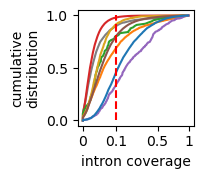

In [17]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
colores = ['tab:blue', 'tab:purple', 'tab:brown', 'tab:orange', 'goldenrod',  'tab:green', 'tab:red', 'tab:gray'][::-1]

for i, label in enumerate(['snmf_and_gencode_and_vastdb', 'snmf_and_gencode', 'snmf_and_vastdb', 'snmf_only',
                   'gencode_and_vastdb','gencode_only', 'vastdb_only', 'no_intron_retention'][::-1]):
    df_ = df.loc[df.label == label]
    c = colores[i]
    ax.plot(np.array(df_.ir_percent.sort_values()), np.linspace(0, 1, len(df_)), c=c, label=label)

ax.plot([np.sqrt(0.1), np.sqrt(0.1)], [0, 1], 'r--')

ax.set_xticks([0, np.sqrt(0.1),  np.sqrt(0.5), np.sqrt(1)], ['0',  '0.1','0.5', '1'], rotation=0)
ax.set_ylabel('cumulative\ndistribution')
# ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('intron coverage')

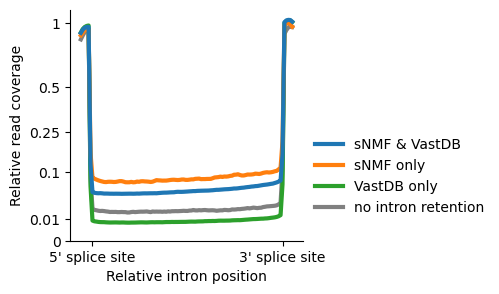

In [19]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_mat(pd.concat([liver_snmf_vastdb_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:blue', zorder = 5, label='sNMF & VastDB')

plot_mat(pd.concat([liver_snmf_gencode_mat, liver_snmf_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:orange', zorder = 4, label='sNMF only')

plot_mat(pd.concat([liver_vastdb_mat, liver_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:green', zorder = 2, label='VastDB only')

# plot_mat(liver_snmf_vastdb_mat, exon_bins, pos_names, ax=ax, c ='tab:brown',  zorder = 4, label='sNMF and VastDB')

# plot_mat(liver_gencode_vastdb_mat, exon_bins, pos_names, ax=ax, c = 'goldenrod', zorder = 4, label='Gencode and VastDB')
# plot_mat(liver_snmf_mat, exon_bins, pos_names, ax=ax, c='tab:orange', zorder=3, label='sNMF only')
# plot_mat(liver_gencode_mat, exon_bins, pos_names, ax=ax, c='tab:green', zorder=2, label='Gencode only')
# plot_mat(liver_vastdb_mat, exon_bins, pos_names, ax=ax, c='tab:red', zorder=2, label='VastDB only')
plot_mat(pd.concat([liver_appris_mat, liver_gencode_mat], axis=0).reset_index(drop=True), exon_bins, pos_names, ax=ax, c='gray', zorder=1, label='no intron retention')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([6, 104], ["5' splice site", "3' splice site"])
ax.set_xlabel('Relative intron position')


ax.set_yticks([0, np.sqrt(0.01), np.sqrt(0.1), np.sqrt(0.25), np.sqrt(0.5), np.sqrt(1)], ['0', '0.01', '0.1', '0.25', '0.5', '1'])

ax.set_ylabel('Relative read coverage')
ax.legend(frameon=False, bbox_to_anchor=(1, 0., 0.5, 0.5))


# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/intron_metaplots.png', bbox_inches='tight', dpi=500)

In [1]:
58532 + 83553 + 1992

144077